In [80]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

import pickle
from tqdm import tqdm
import os
import xgboost as xgb
from xgboost import XGBRegressor
plt.rcParams['figure.figsize'] = (12,7)

## Reading Data and EDA

In [12]:
train = pd.read_csv('train/train.csv')
fc = pd.read_csv('train/fulfilment_center_info.csv')
meal = pd.read_csv('train/meal_info.csv')

In [3]:
train.shape

(456548, 9)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [5]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [6]:
train.nunique()

id                       456548
week                        145
center_id                    77
meal_id                      51
checkout_price             1992
base_price                 1907
emailer_for_promotion         2
homepage_featured             2
num_orders                 1250
dtype: int64

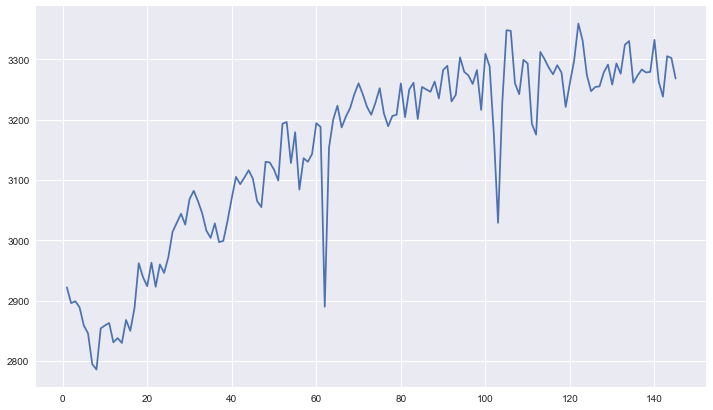

In [13]:
plt.plot(train.groupby('week').size())

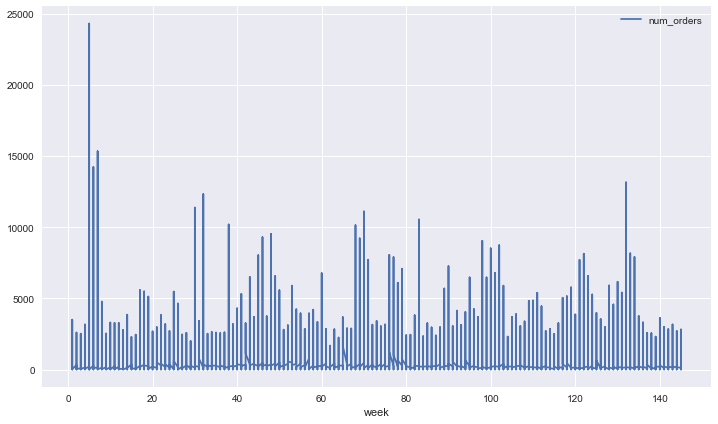

In [14]:
train.plot('week', 'num_orders')

In [15]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [16]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [17]:
print(meal['meal_id'].nunique())
print(train['meal_id'].nunique())
# print(test['meal_id'].nunique())

51
51


In [18]:
fc.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [20]:
print(fc[['city_code', 'region_code']].nunique())
# fc.groupby(['city_code', 'region_code']).count()

city_code      51
region_code     8
dtype: int64


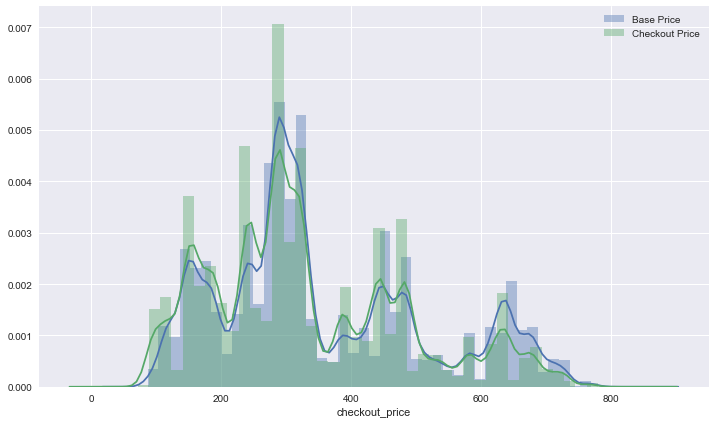

In [21]:
sns.distplot(train['base_price'], label='Base Price')
sns.distplot(train['checkout_price'], label='Checkout Price')
plt.legend()

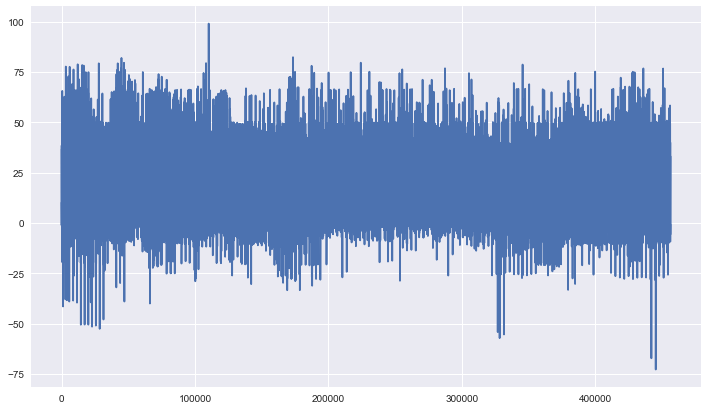

In [22]:
train['disc_pc'] = (train['base_price'] - train['checkout_price'])*100.0/train['base_price']
plt.plot(train['disc_pc'])
# plt.plot(train['num_orders'])

In [23]:
test = pd.read_csv('test_QoiMO9B.csv')
print(test.shape)
test.head()

(32573, 8)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [121]:
print(test.info())
test.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
dtypes: float64(2), int64(6)
memory usage: 2.0 MB
None


id                       32573
week                        10
center_id                   77
meal_id                     51
checkout_price            1397
base_price                1179
emailer_for_promotion        2
homepage_featured            2
dtype: int64

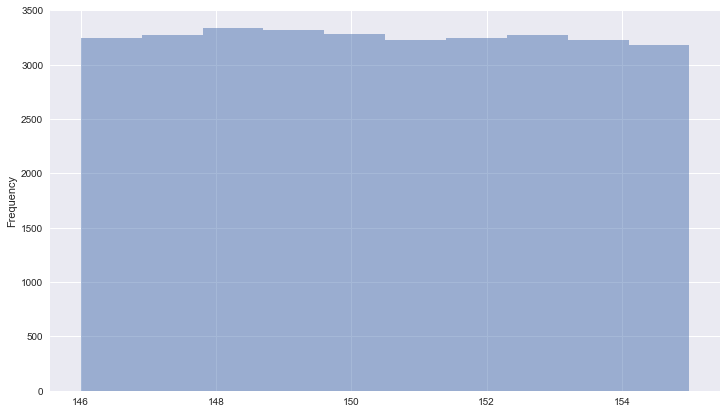

In [24]:
test['week'].plot.hist(alpha=0.5)

In [25]:
test['meal_id'].nunique()

51

In [26]:
print(len(set(test['meal_id']) - set(meal['meal_id'])))
print(len(set(train['meal_id']) - set(meal['meal_id'])))

0
0


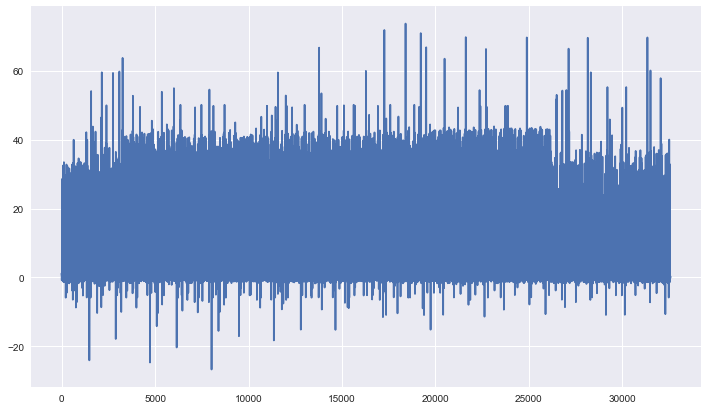

In [27]:
test['disc_pc'] = (test['base_price'] - test['checkout_price'])*100.0/test['base_price']
test['disc_pc'].plot()

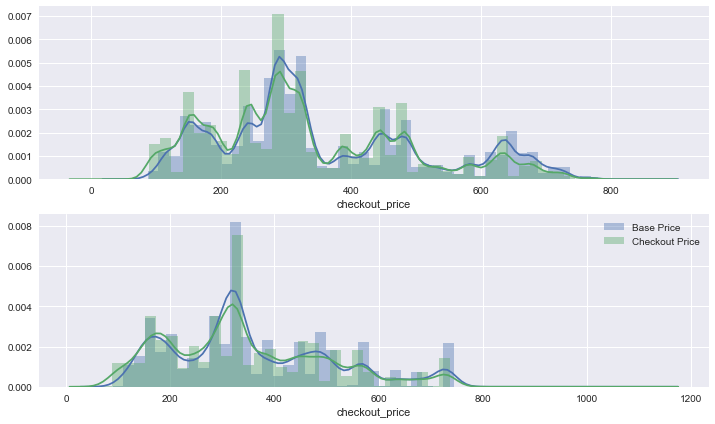

In [28]:
plt.subplot(211)
sns.distplot(train['base_price'], label='Base Price')
sns.distplot(train['checkout_price'], label='Checkout Price')
plt.subplot(212)
sns.distplot(test['base_price'], label='Base Price')
sns.distplot(test['checkout_price'], label='Checkout Price')
plt.legend()
plt.show()

In [29]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,disc_pc
0,1379560,1,55,1885,136.83,152.29,0,0,177,10.151684
1,1466964,1,55,1993,136.83,135.83,0,0,270,-0.736214
2,1346989,1,55,2539,134.86,135.86,0,0,189,0.736052
3,1338232,1,55,2139,339.50,437.53,0,0,54,22.405321
4,1448490,1,55,2631,243.50,242.50,0,0,40,-0.412371


In [30]:
train = pd.merge(train, fc, on='center_id', how='left')

In [31]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,disc_pc,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,10.151684,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,-0.736214,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,0.736052,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,22.405321,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,-0.412371,647,56,TYPE_C,2.0


In [32]:
test = pd.merge(test, fc, on='center_id', how='left')
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,0.628496,647,56,TYPE_C,2.0
1,1127204,146,55,1993,160.11,159.11,0,0,-0.628496,647,56,TYPE_C,2.0
2,1212707,146,55,2539,157.14,159.14,0,0,1.256755,647,56,TYPE_C,2.0
3,1082698,146,55,2631,162.02,162.02,0,0,0.000000,647,56,TYPE_C,2.0
4,1400926,146,55,1248,163.93,163.93,0,0,0.000000,647,56,TYPE_C,2.0


In [33]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [34]:
train = pd.merge(train, meal, how='left', on='meal_id')
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,disc_pc,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,10.151684,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,-0.736214,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,0.736052,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,22.405321,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,-0.412371,647,56,TYPE_C,2.0,Beverages,Indian


In [35]:
train.isnull().any()

id                       False
week                     False
center_id                False
meal_id                  False
checkout_price           False
base_price               False
emailer_for_promotion    False
homepage_featured        False
num_orders               False
disc_pc                  False
city_code                False
region_code              False
center_type              False
op_area                  False
category                 False
cuisine                  False
dtype: bool

In [36]:
train.isna().any()

id                       False
week                     False
center_id                False
meal_id                  False
checkout_price           False
base_price               False
emailer_for_promotion    False
homepage_featured        False
num_orders               False
disc_pc                  False
city_code                False
region_code              False
center_type              False
op_area                  False
category                 False
cuisine                  False
dtype: bool

In [37]:
test = pd.merge(test, meal, how='left', on='meal_id')
print(test.isna().any())
print("="*50)
print(test.isnull().any())
test.head()

id                       False
week                     False
center_id                False
meal_id                  False
checkout_price           False
base_price               False
emailer_for_promotion    False
homepage_featured        False
disc_pc                  False
city_code                False
region_code              False
center_type              False
op_area                  False
category                 False
cuisine                  False
dtype: bool
id                       False
week                     False
center_id                False
meal_id                  False
checkout_price           False
base_price               False
emailer_for_promotion    False
homepage_featured        False
disc_pc                  False
city_code                False
region_code              False
center_type              False
op_area                  False
category                 False
cuisine                  False
dtype: bool


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,center_type,op_area,category,cuisine
0,1028232,146,55,1885,158.11,159.11,0,0,0.628496,647,56,TYPE_C,2.0,Beverages,Thai
1,1127204,146,55,1993,160.11,159.11,0,0,-0.628496,647,56,TYPE_C,2.0,Beverages,Thai
2,1212707,146,55,2539,157.14,159.14,0,0,1.256755,647,56,TYPE_C,2.0,Beverages,Thai
3,1082698,146,55,2631,162.02,162.02,0,0,0.000000,647,56,TYPE_C,2.0,Beverages,Indian
4,1400926,146,55,1248,163.93,163.93,0,0,0.000000,647,56,TYPE_C,2.0,Beverages,Indian


In [38]:
train.nunique()

id                       456548
week                        145
center_id                    77
meal_id                      51
checkout_price             1992
base_price                 1907
emailer_for_promotion         2
homepage_featured             2
num_orders                 1250
disc_pc                   46098
city_code                    51
region_code                   8
center_type                   3
op_area                      30
category                     14
cuisine                       4
dtype: int64

In [39]:
test.nunique()

id                       32573
week                        10
center_id                   77
meal_id                     51
checkout_price            1397
base_price                1179
emailer_for_promotion        2
homepage_featured            2
disc_pc                   5566
city_code                   51
region_code                  8
center_type                  3
op_area                     30
category                    14
cuisine                      4
dtype: int64

In [40]:
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'disc_pc',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine'],
      dtype='object')

In [133]:
# categorical_cols = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine']
# le = LabelEncoder()
# for c in categorical_cols:
#     le.fit(train[c])
#     train[c] = le.transform(train[c])
#     test[c] = le.transform(test[c])

# train.head()

In [134]:
# test.head()

In [64]:
os.listdir()

['.ipynb_checkpoints',
 'P1.ipynb',
 'sample_submission_hSlSoT6.csv',
 'test_QoiMO9B.csv',
 'train',
 'Week2-Validation.pdf']

In [41]:
id_train = train['id']
X = train.drop(['id', 'num_orders'], axis=1)
y = train['num_orders']

In [42]:
test['week'].nunique()/train['week'].nunique()

0.06896551724137931

In [43]:
train.shape

(456548, 16)

In [76]:
# params_xgb = {
#     "n_estimators": [100, 500, 1000, 1500],
#     "max_depth": [3, 5, 7, 8]
# #     "learning_rate":np.logspace(-2, 1, 4),
# #     "colsample_bytree": [0.3, 0.5, 0.75, 1],
# #     "col_sample_by_level": [0.5, 0.75, 1],
# #     "subsample": [0.5, 0.6, 0.8, 1],
# #     "reg_lambda": [0.5, 0.8, 1]
# }

# clf_xgb = RandomizedSearchCV(XGBRegressor(), params_xgb, n_iter=10, cv=KFold(5), n_jobs=-1, random_state=0, 
#                              scoring='neg_mean_squared_log_error', verbose=2)

# clf_xgb.fit(X, y)

In [139]:
X.columns[1:]

Index(['center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'disc_pc', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine'],
      dtype='object')

## Trial 1

In [82]:
#X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.689)
categorical_feats = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'city_code',
                     'region_code', 'center_type', 'op_area', 'category', 'cuisine']
## https://github.com/catboost/tutorials/blob/master/hyperparameters_tuning/hyperparameters_tuning.ipynb
from catboost import CatBoostRegressor, Pool
train_pool = Pool(X, y, cat_features=categorical_feats)
# test_pool = Pool(X_cv, y_cv, cat_features=categorical_feats)
# type(test_pool)
model = CatBoostRegressor(iterations=2500, task_type='GPU')
grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'depth':[3, 5, 8]
}
grid_search_results = model.grid_search(grid, train_pool, shuffle=False, verbose=3)

0:	loss: 188.9098385	best: 188.9098385 (0)	total: 2m 15s	remaining: 24m 47s
3:	loss: 182.4885943	best: 175.7312990 (2)	total: 8m 40s	remaining: 17m 21s
6:	loss: 170.3071826	best: 168.3140933 (5)	total: 18m 56s	remaining: 13m 32s
9:	loss: 167.4272865	best: 167.4272865 (9)	total: 34m 8s	remaining: 6m 49s
11:	loss: 183.7367079	best: 167.4272865 (9)	total: 45m 51s	remaining: 0us
Estimating final quality...


In [84]:
print("Best Params: ", grid_search_results['params'])

Best Params:  {'depth': 8, 'learning_rate': 0.1}


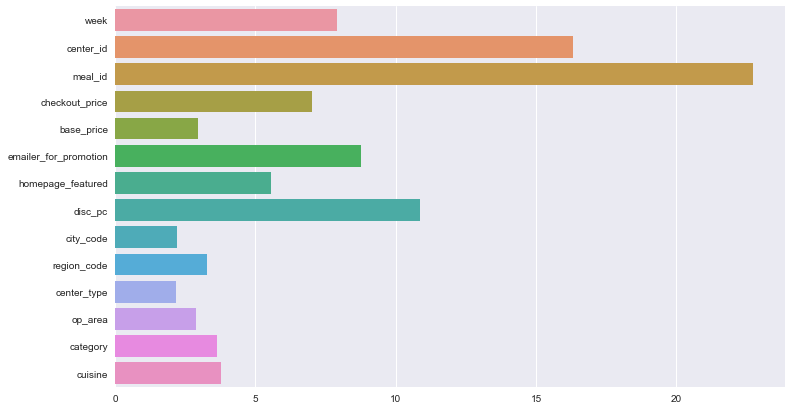

In [91]:
sns.barplot(model.feature_importances_, X.columns)
plt.show()

In [93]:
X_test = test[X.columns]
X_test.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,center_type,op_area,category,cuisine
0,146,55,1885,158.11,159.11,0,0,0.628496,30,3,2,2,0,3
1,146,55,1993,160.11,159.11,0,0,-0.628496,30,3,2,2,0,3
2,146,55,2539,157.14,159.14,0,0,1.256755,30,3,2,2,0,3
3,146,55,2631,162.02,162.02,0,0,0.000000,30,3,2,2,0,1
4,146,55,1248,163.93,163.93,0,0,0.000000,30,3,2,2,0,1


In [111]:
y_test = model.predict(X_test)
y_test = np.array([max(int(i), 0) for i in y_test])

In [112]:
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_test})
sub_df.to_csv('submitfile.csv', index=False)

In [113]:
y_test[y_test<0]

array([], dtype=int32)

## Trial 2

In [115]:
train['category'].value_counts()

0     127890
8      33408
10     33291
7      33138
13     29941
5      29379
2      29294
9      28559
6      27694
11     26916
1      20614
3      13562
12     12675
4      10187
Name: category, dtype: int64

In [44]:
train['op_area'] = train['op_area'].astype(str)
test['op_area'] = test['op_area'].astype(str)

In [152]:
from sklearn.metrics import mean_squared_log_error
cat_features = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine']
model_cat1 = CatBoostRegressor(random_seed=0, task_type='GPU')
features = [c for c in train.columns if c not in ['id', 'num_orders']]
# features
model_cat1.fit(train[features], train['num_orders'], cat_features=cat_features, plot=True, verbose=False, )
y_pred_train = model.predict(train[features])
y_pred_train = [max(int(i), 0) for i in y_pred_train]
print("Train RMSLE: ", np.sqrt(mean_squared_log_error(train['num_orders'], y_pred_train)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train RMSLE:  2.172899467201646


In [153]:
y_pred = model_cat1.predict(test[features])
y_pred = [max(int(i), 0) for i in y_pred]
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.to_csv('submitfile1.csv', index=False)

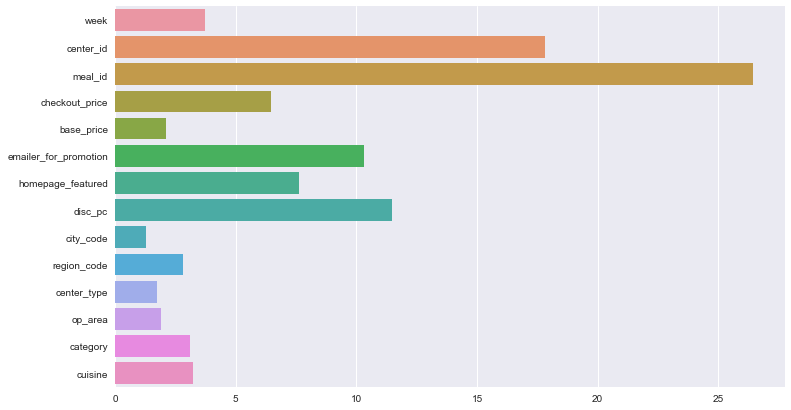

In [157]:
sns.barplot(model_cat1.feature_importances_, np.array(features))
plt.show()

## New Features

In [154]:
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'disc_pc',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine'],
      dtype='object')

In [45]:
train['email_homepage'] = train['emailer_for_promotion'] + train['homepage_featured']
test['email_homepage'] = test['emailer_for_promotion'] + test['homepage_featured']
train['is_discounted'] = train['checkout_price'] < train['base_price']
test['is_discounted'] = test['checkout_price'] < test['base_price']
train['cat_cuisine'] = train['category'].astype(str) + '_' + train['cuisine'].astype(str)
test['cat_cuisine'] = test['category'].astype(str) + '_' + test['cuisine'].astype(str)
train['city_region'] = train['city_code'].astype(str) + '_' + train['region_code'].astype(str)
test['city_region'] = test['city_code'].astype(str) + '_' + test['region_code'].astype(str)
train['center_meal_id'] = train['city_code'].astype(str) + '_' + train['meal_id'].astype(str)
test['center_meal_id'] = test['city_code'].astype(str) + '_' + test['meal_id'].astype(str)

In [46]:
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'disc_pc',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine', 'email_homepage', 'is_discounted', 'cat_cuisine',
       'city_region', 'center_meal_id'],
      dtype='object')

In [47]:
def getAllCatFeatures():
    features = [c for c in train.columns if c not in ['id', 'num_orders']]
    cat_indices = []
    cat_features = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine', 
                   'email_homepage', 'is_discounted', 'cat_cuisine', 'city_region', 'center_meal_id']
    for i, c in enumerate(features):
        if c in cat_features:
            cat_indices.append(i)
            print(i, c)
    return features, cat_features

features, cat_features = getAllCatFeatures()

1 center_id
2 meal_id
8 city_code
9 region_code
10 center_type
11 op_area
12 category
13 cuisine
14 email_homepage
15 is_discounted
16 cat_cuisine
17 city_region
18 center_meal_id


In [182]:
model_cat2 = CatBoostRegressor(random_seed=0, task_type='GPU')
model_cat2.fit(train[features], train['num_orders'], cat_features=cat_indices, plot=True, verbose=False, )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train RMSLE:  0.5926897877356587


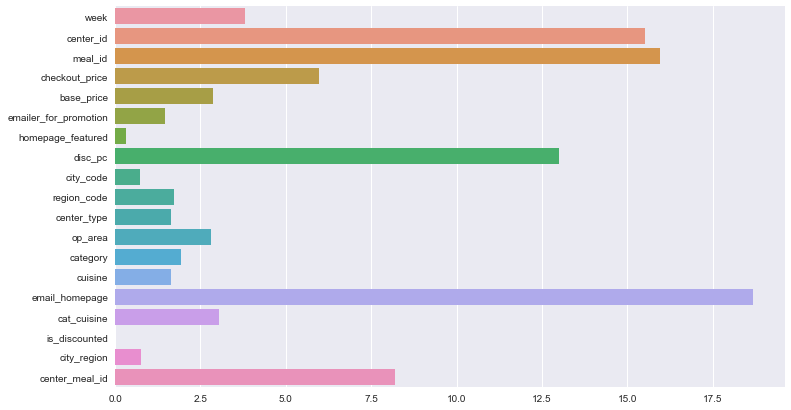

In [183]:
y_pred_train = model_cat2.predict(train[features])
y_pred_train = [max(int(i), 0) for i in y_pred_train]
print("Train RMSLE: ", np.sqrt(mean_squared_log_error(train['num_orders'], y_pred_train)))
sns.barplot(model_cat2.feature_importances_, np.array(features))
plt.show()
y_pred = model_cat2.predict(test[features])
y_pred = [max(int(i), 0) for i in y_pred]
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.to_csv('submitfile2.csv', index=False)

In [185]:
max(y_pred_train)

14216

## More features 3

In [187]:
train['disc_pc'].nunique()

46098

In [188]:
train.drop(['is_discounted'], axis=1, inplace=True)
test.drop(['is_discounted'], axis=1, inplace=True)
train['center_meal_discount'] = train['center_meal_id'].astype(str) + '_' + train['disc_pc'].astype(str)
test['center_meal_discount'] = test['center_meal_id'].astype(str) + '_' + test['disc_pc'].astype(str)
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'disc_pc',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine', 'email_homepage', 'cat_cuisine', 'city_region',
       'center_meal_id', 'center_meal_discount'],
      dtype='object')

1 center_id
2 meal_id
8 city_code
9 region_code
10 center_type
11 op_area
12 category
13 cuisine
14 email_homepage
15 cat_cuisine
16 city_region
17 center_meal_id


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train RMSLE:  0.5623484031307064


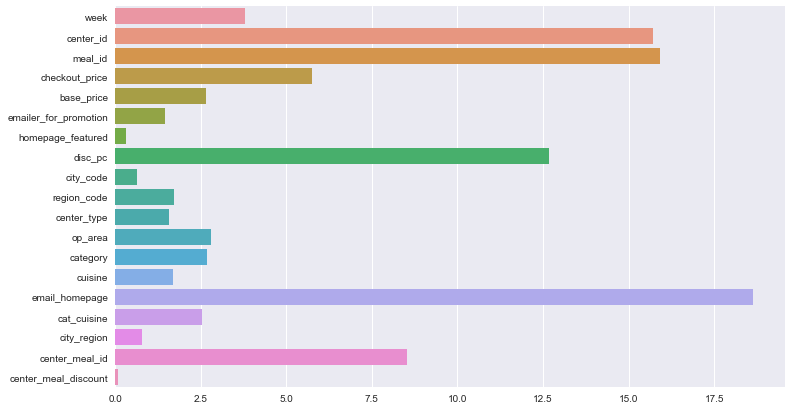

In [189]:
features, cat_features = getAllCatFeatures()
model_cat3 = CatBoostRegressor(random_seed=0, task_type='GPU')
model_cat3.fit(train[features], train['num_orders'], cat_features=cat_indices, plot=True, verbose=False)

y_pred_train = model_cat3.predict(train[features])
y_pred_train = [max(int(i), 0) for i in y_pred_train]
print("Train RMSLE: ", np.sqrt(mean_squared_log_error(train['num_orders'], y_pred_train)))
sns.barplot(model_cat3.feature_importances_, np.array(features))
plt.show()
y_pred = model_cat3.predict(test[features])
y_pred = [max(int(i), 0) for i in y_pred]
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.to_csv('submitfile2.csv', index=False)

## Adding Cyclical features

Since week numbers here are more than 52, which is the no. of weeks in a year, we will need to produce cyclical features like sine and cosine of week nos., having a time period of 52.

In [48]:
train['center_meal_discount'] = train['center_meal_id'].astype(str) + '_' + train['disc_pc'].astype(str)
test['center_meal_discount'] = test['center_meal_id'].astype(str) + '_' + test['disc_pc'].astype(str)
# train.drop(['center_meal_discount'], axis=1, inplace=True)
# test.drop(['center_meal_discount'], axis=1, inplace=True)
train['week_sin'] = np.sin(2*np.pi*train['week']/52)
train['week_cos'] = np.cos(2*np.pi*train['week']/52)
test['week_sin'] = np.sin(2*np.pi*test['week']/52)
test['week_cos'] = np.cos(2*np.pi*test['week']/52)
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'disc_pc',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine', 'email_homepage', 'is_discounted', 'cat_cuisine',
       'city_region', 'center_meal_id', 'center_meal_discount', 'week_sin',
       'week_cos'],
      dtype='object')

In [201]:
features = [c for c in train.columns if c not in['id', 'num_orders']]
print(len(features))
print(features)
cat_indices = [1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]

21
['week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'disc_pc', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine', 'email_homepage', 'cat_cuisine', 'city_region', 'center_meal_id', 'week_sin', 'week_cos', 'center_meal_discount']


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train RMSLE:  0.6449665641421949


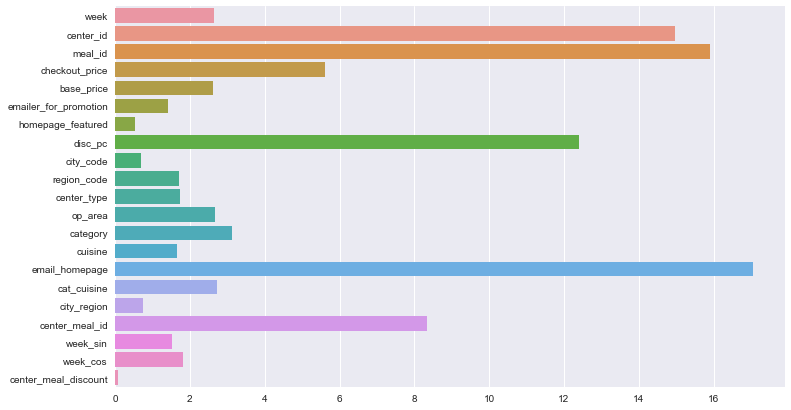

In [204]:
model_cat4 = CatBoostRegressor(random_seed=0, task_type='GPU', iterations=1500)
model_cat4.fit(train[features], train['num_orders'], cat_features=cat_indices, plot=True, verbose=False)

y_pred_train = model_cat4.predict(train[features])
y_pred_train = [max(int(i), 0) for i in y_pred_train]
print("Train RMSLE: ", np.sqrt(mean_squared_log_error(train['num_orders'], y_pred_train)))
sns.barplot(model_cat4.feature_importances_, np.array(features))
plt.show()
y_pred = model_cat4.predict(test[features])
y_pred = [max(int(i), 0) for i in y_pred]
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.to_csv('submitfile4.csv', index=False)

In [207]:
min(y_pred)

0

## Tuning again

In [55]:
train.drop(['is_discounted', 'center_meal_discount'], axis=1, inplace=True)
test.drop(['is_discounted', 'center_meal_discount'], axis=1, inplace=True)
train.nunique()

id                       456548
week                        145
center_id                    77
meal_id                      51
checkout_price             1992
base_price                 1907
emailer_for_promotion         2
homepage_featured             2
num_orders                 1250
disc_pc                   46098
city_code                    51
region_code                   8
center_type                   3
op_area                      30
category                     14
cuisine                       4
email_homepage                3
cat_cuisine                  17
city_region                  51
center_meal_id             2379
week_sin                    120
week_cos                    121
dtype: int64

In [6]:
# print(cat_indices)
features = [c for c in train.columns if c not in ['id', 'num_orders', 'num_orders_log1p']]
for i, c in enumerate(features):
    print(i, c)

0 week
1 center_id
2 meal_id
3 checkout_price
4 base_price
5 emailer_for_promotion
6 homepage_featured
7 disc_pc
8 city_code
9 region_code
10 center_type
11 op_area
12 category
13 cuisine
14 email_homepage
15 cat_cuisine
16 city_region
17 center_meal_id
18 week_sin
19 week_cos


In [3]:
# train.to_csv('train_processed.csv', index=False)
# test.to_csv('test_processed.csv', index=False)
train = pd.read_csv('train_processed.csv')
test = pd.read_csv('test_processed.csv')
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,...,center_type,op_area,category,cuisine,email_homepage,cat_cuisine,city_region,center_meal_id,week_sin,week_cos
0,1028232,146,55,1885,158.11,159.11,0,0,0.628496,647,...,TYPE_C,2.0,Beverages,Thai,0,Beverages_Thai,647_56,647_1885,-0.935016,0.354605
1,1127204,146,55,1993,160.11,159.11,0,0,-0.628496,647,...,TYPE_C,2.0,Beverages,Thai,0,Beverages_Thai,647_56,647_1993,-0.935016,0.354605
2,1212707,146,55,2539,157.14,159.14,0,0,1.256755,647,...,TYPE_C,2.0,Beverages,Thai,0,Beverages_Thai,647_56,647_2539,-0.935016,0.354605
3,1082698,146,55,2631,162.02,162.02,0,0,0.000000,647,...,TYPE_C,2.0,Beverages,Indian,0,Beverages_Indian,647_56,647_2631,-0.935016,0.354605
4,1400926,146,55,1248,163.93,163.93,0,0,0.000000,647,...,TYPE_C,2.0,Beverages,Indian,0,Beverages_Indian,647_56,647_1248,-0.935016,0.354605


In [10]:
train['num_orders_log1p'] = np.log1p(train['num_orders'])
train['op_area'] = train['op_area'].astype(str)
test['op_area'] = test['op_area'].astype(str)

In [40]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.05, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9],
          'iterations': [500, 1000, 1500, 2000]}

cat_indices = [1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
# cb_model = GridSearchCV(CatBoostRegressor(task_type='GPU', silent=True), params, scoring="neg_mean_squared_log_error", 
#                         cv = 3, verbose=3, n_jobs=-1)
# cb_model.fit(train[features], train['num_orders'], cat_features=cat_indices)

from catboost import CatBoostRegressor, Pool
train_pool = Pool(train[features], train['num_orders_log1p'], cat_features=cat_indices)
# test_pool = Pool(X_cv, y_cv, cat_features=categorical_feats)
# type(test_pool)
model = CatBoostRegressor(task_type='GPU', one_hot_max_size=77)
# grid = {
#     'learning_rate': [0.01, 0.1, 0.5, 1],
#     'depth':[3, 5, 8]
# }
grid_search_results = model.randomized_search(params, train_pool, shuffle=False, verbose=3, n_iter=40)

0:	loss: 0.5575349	best: 0.5575349 (0)	total: 22.3s	remaining: 14m 29s
3:	loss: 0.5516409	best: 0.5516409 (3)	total: 2m 3s	remaining: 18m 32s
6:	loss: 0.5451122	best: 0.5451122 (6)	total: 4m 28s	remaining: 21m 4s
9:	loss: 0.5402662	best: 0.5402662 (9)	total: 8m 37s	remaining: 25m 51s
12:	loss: 0.5515928	best: 0.5402662 (9)	total: 10m 2s	remaining: 20m 52s
15:	loss: 0.5547153	best: 0.5402662 (9)	total: 11m 29s	remaining: 17m 14s
18:	loss: 0.5510246	best: 0.5402662 (9)	total: 14m 1s	remaining: 15m 30s
21:	loss: 0.5332349	best: 0.5332349 (21)	total: 17m 54s	remaining: 14m 38s
24:	loss: 0.5436573	best: 0.5332349 (21)	total: 22m 3s	remaining: 13m 13s
27:	loss: 0.6865525	best: 0.5332349 (21)	total: 24m 48s	remaining: 10m 37s
30:	loss: 0.5914379	best: 0.5332349 (21)	total: 26m 57s	remaining: 7m 49s
33:	loss: 0.6572004	best: 0.5332349 (21)	total: 29m 46s	remaining: 5m 15s
36:	loss: 0.6425010	best: 0.5332349 (21)	total: 34m	remaining: 2m 45s
39:	loss: 0.6226719	best: 0.5263001 (37)	total: 40m 3

In [41]:
grid_search_results['params']

{'depth': 10, 'l2_leaf_reg': 4, 'iterations': 2000, 'learning_rate': 0.1}

learning_rate: 0.1000000015
depth: 10
l2_leaf_reg: 4
iterations: 2000


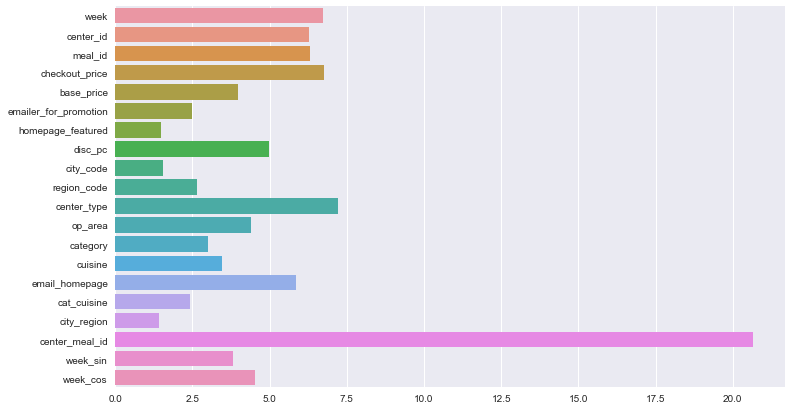

In [42]:
for param, v in params.items():
    print("{}: {}".format(param, model.get_all_params()[param]))

sns.barplot(model.feature_importances_, np.array(features))
plt.show()

In [43]:
y_pred = model.predict(test[features])
y_pred = np.expm1(y_pred)
y_pred = np.array([int(i) for i in y_pred])
y_pred[y_pred<0]

array([], dtype=int32)

In [44]:
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.head()

,id,num_orders
0,1028232,164
1,1127204,88
2,1212707,111
3,1082698,53
4,1400926,37


In [45]:
sub_df.to_csv('submitfile_5.csv', index=False)

## Removing some features

In [46]:
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'disc_pc',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine', 'email_homepage', 'cat_cuisine', 'city_region',
       'center_meal_id', 'week_sin', 'week_cos', 'num_orders_log1p'],
      dtype='object')

In [47]:
train.drop(['cat_cuisine', 'city_region'], axis=1, inplace=True)
test.drop(['cat_cuisine', 'city_region'], axis=1, inplace=True)
features = [c for c in train.columns if c not in ['id', 'num_orders', 'num_orders_log1p']]
for i, c in enumerate(features):
    print(i, c)

0 week
1 center_id
2 meal_id
3 checkout_price
4 base_price
5 emailer_for_promotion
6 homepage_featured
7 disc_pc
8 city_code
9 region_code
10 center_type
11 op_area
12 category
13 cuisine
14 email_homepage
15 center_meal_id
16 week_sin
17 week_cos


In [49]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.05, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9],
          'iterations': [1000, 1500, 2000, 2500],
          'one_hot_max_size': [51, 77]
         }

cat_indices = [1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
# cb_model = GridSearchCV(CatBoostRegressor(task_type='GPU', silent=True), params, scoring="neg_mean_squared_log_error", 
#                         cv = 3, verbose=3, n_jobs=-1)
# cb_model.fit(train[features], train['num_orders'], cat_features=cat_indices)

from catboost import CatBoostRegressor, Pool
train_pool = Pool(train[features], train['num_orders_log1p'], cat_features=cat_indices)
# test_pool = Pool(X_cv, y_cv, cat_features=categorical_feats)
# type(test_pool)
model = CatBoostRegressor(task_type='GPU', early_stopping_rounds=40)
# grid = {
#     'learning_rate': [0.01, 0.1, 0.5, 1],
#     'depth':[3, 5, 8]
# }
grid_search_results = model.randomized_search(params, train_pool, shuffle=False, verbose=3, n_iter=50)

0:	loss: 0.5674536	best: 0.5674536 (0)	total: 13.5s	remaining: 10m 59s
3:	loss: 0.5627397	best: 0.5522872 (1)	total: 1m 30s	remaining: 17m 17s
6:	loss: 0.5507687	best: 0.5507687 (6)	total: 2m 14s	remaining: 13m 45s
9:	loss: 0.5529854	best: 0.5494931 (8)	total: 3m 32s	remaining: 14m 10s
12:	loss: 0.5488029	best: 0.5482165 (10)	total: 6m	remaining: 17m 6s
15:	loss: 0.5752089	best: 0.5482165 (10)	total: 6m 38s	remaining: 14m 5s
18:	loss: 0.5432030	best: 0.5432030 (18)	total: 7m 32s	remaining: 12m 17s
21:	loss: 0.5513039	best: 0.5432030 (18)	total: 9m 8s	remaining: 11m 38s
24:	loss: 0.5633697	best: 0.5432030 (18)	total: 10m 18s	remaining: 10m 18s
27:	loss: 0.5660492	best: 0.5432030 (18)	total: 11m 30s	remaining: 9m 2s
30:	loss: 0.5503671	best: 0.5432030 (18)	total: 12m 16s	remaining: 7m 31s
33:	loss: 0.6594930	best: 0.5432030 (18)	total: 13m 53s	remaining: 6m 32s
36:	loss: 0.5981410	best: 0.5432030 (18)	total: 15m 16s	remaining: 5m 22s
39:	loss: 0.6405461	best: 0.5432030 (18)	total: 16m 20

In [50]:
grid_search_results['params']

{'depth': 7,
 'one_hot_max_size': 51,
 'l2_leaf_reg': 1,
 'iterations': 1500,
 'learning_rate': 0.05}

Optimal Hyperparameters:
one_hot_max_size: 51
learning_rate: 0.05000000075
depth: 7
l2_leaf_reg: 1
iterations: 1500


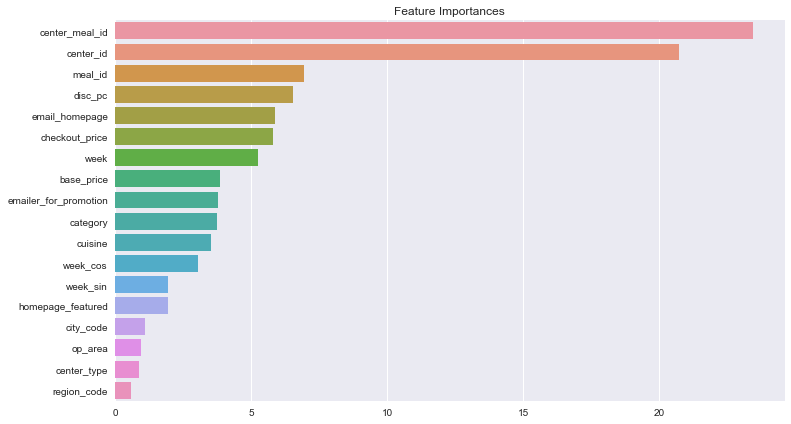

In [67]:
print("Optimal Hyperparameters:")
for param, v in params.items():
    print("{}: {}".format(param, model.get_all_params()[param]))
print("="*50)
sns.barplot(np.sort(model.feature_importances_)[::-1], np.take(features, np.argsort(model.feature_importances_))[::-1])
plt.title('Feature Importances')
plt.show()

In [52]:
y_pred = model.predict(test[features])
y_pred = np.expm1(y_pred)
y_pred = np.array([int(i) for i in y_pred])
y_pred[y_pred<0]

array([], dtype=int32)

In [53]:
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.head()
sub_df.to_csv('submitfile_6.csv', index=False)

,id,num_orders
0,1028232,174
1,1127204,125
2,1212707,139
3,1082698,38
4,1400926,30


## Random Forest

In [69]:
from sklearn.preprocessing import LabelEncoder
# Copying to New Dataset for Label Encoding to use with Random Forest
train_new = train[features].copy()
test_new = test[features].copy()
le = LabelEncoder()
for i, c in enumerate(features):
    if i in cat_indices:
        le.fit(train_new[c])
        train_new[c] = le.transform(train_new[c])
        test_new[c] = le.transform(test_new[c])

train_new.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,center_type,op_area,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos
0,1,23,22,136.83,152.29,0,0,10.151684,30,3,2,2,0,3,0,1415,0.120537,0.992709
1,1,23,26,136.83,135.83,0,0,-0.736214,30,3,2,2,0,3,0,1419,0.120537,0.992709
2,1,23,38,134.86,135.86,0,0,0.736052,30,3,2,2,0,3,0,1430,0.120537,0.992709
3,1,23,29,339.50,437.53,0,0,22.405321,30,3,2,2,0,1,0,1421,0.120537,0.992709
4,1,23,42,243.50,242.50,0,0,-0.412371,30,3,2,2,0,1,0,1434,0.120537,0.992709


In [71]:
test_new.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,center_type,op_area,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos
0,146,23,22,158.11,159.11,0,0,0.628496,30,3,2,2,0,3,0,1415,-0.935016,0.354605
1,146,23,26,160.11,159.11,0,0,-0.628496,30,3,2,2,0,3,0,1419,-0.935016,0.354605
2,146,23,38,157.14,159.14,0,0,1.256755,30,3,2,2,0,3,0,1430,-0.935016,0.354605
3,146,23,42,162.02,162.02,0,0,0.000000,30,3,2,2,0,1,0,1434,-0.935016,0.354605
4,146,23,7,163.93,163.93,0,0,0.000000,30,3,2,2,0,1,0,1400,-0.935016,0.354605


In [84]:
from datetime import datetime, timedelta
start = datetime(2015, 8, 1)
# start
train_new['dummyDate'] = train_new['week'].apply(lambda x: start + timedelta(weeks=x))
test_new['dummyDate'] = test_new['week'].apply(lambda x: start + timedelta(weeks=x))

train_new.set_index('dummyDate', drop=True, inplace=True)
test_new.set_index('dummyDate', drop=True, inplace=True)
train_new.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,center_type,op_area,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos
dummyDate,,,,,,,,,,,,,,,,,,
2015-08-08,1,23,22,136.83,152.29,0,0,10.151684,30,3,2,2,0,3,0,1415,0.120537,0.992709
2015-08-08,1,23,26,136.83,135.83,0,0,-0.736214,30,3,2,2,0,3,0,1419,0.120537,0.992709
2015-08-08,1,23,38,134.86,135.86,0,0,0.736052,30,3,2,2,0,3,0,1430,0.120537,0.992709
2015-08-08,1,23,29,339.50,437.53,0,0,22.405321,30,3,2,2,0,1,0,1421,0.120537,0.992709
2015-08-08,1,23,42,243.50,242.50,0,0,-0.412371,30,3,2,2,0,1,0,1434,0.120537,0.992709


In [85]:
test_new.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,center_type,op_area,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos
dummyDate,,,,,,,,,,,,,,,,,,
2018-05-19,146,23,22,158.11,159.11,0,0,0.628496,30,3,2,2,0,3,0,1415,-0.935016,0.354605
2018-05-19,146,23,26,160.11,159.11,0,0,-0.628496,30,3,2,2,0,3,0,1419,-0.935016,0.354605
2018-05-19,146,23,38,157.14,159.14,0,0,1.256755,30,3,2,2,0,3,0,1430,-0.935016,0.354605
2018-05-19,146,23,42,162.02,162.02,0,0,0.000000,30,3,2,2,0,1,0,1434,-0.935016,0.354605
2018-05-19,146,23,7,163.93,163.93,0,0,0.000000,30,3,2,2,0,1,0,1400,-0.935016,0.354605


In [90]:
rf_params = {
    'n_estimators': [10, 50, 100, 300],
    'max_depth': [50, 100, 150]
}
from sklearn.model_selection import TimeSeriesSplit
model_rf = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=rf_params, scoring='neg_mean_squared_error',
                        cv=TimeSeriesSplit(3))
model_rf.fit(train_new, train['num_orders_log1p'])

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None

In [91]:
model_rf.best_params_

{'max_depth': 50, 'n_estimators': 300}

In [96]:
model.best_score_

{'learn': {'RMSE': 0.46176999953768844}}

In [93]:
y_pred = model_rf.predict(test_new)
y_pred = np.expm1(y_pred)
y_pred = np.array([int(i) for i in y_pred])
y_pred[y_pred<0]

array([], dtype=int32)

In [94]:
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.head()
sub_df.to_csv('submitfile_rf.csv', index=False)

## Implement Time-Based Splitting with dummy date values and CatBoost

In [98]:
# from datetime import datetime, timedelta
start = datetime(2015, 8, 1)
# start
train.index = train_new['week'].apply(lambda x: start + timedelta(weeks=x))
test.index = test_new['week'].apply(lambda x: start + timedelta(weeks=x))

# train_new.set_index('dummyDate', drop=True, inplace=True)
# test_new.set_index('dummyDate', drop=True, inplace=True)
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,disc_pc,...,region_code,center_type,op_area,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos,num_orders_log1p
week,,,,,,,,,,,,,,,,,,,,,
2015-08-08,1379560,1,55,1885,136.83,152.29,0,0,177,10.151684,...,56,TYPE_C,2.0,Beverages,Thai,0,647_1885,0.120537,0.992709,5.181784
2015-08-08,1466964,1,55,1993,136.83,135.83,0,0,270,-0.736214,...,56,TYPE_C,2.0,Beverages,Thai,0,647_1993,0.120537,0.992709,5.602119
2015-08-08,1346989,1,55,2539,134.86,135.86,0,0,189,0.736052,...,56,TYPE_C,2.0,Beverages,Thai,0,647_2539,0.120537,0.992709,5.247024
2015-08-08,1338232,1,55,2139,339.50,437.53,0,0,54,22.405321,...,56,TYPE_C,2.0,Beverages,Indian,0,647_2139,0.120537,0.992709,4.007333
2015-08-08,1448490,1,55,2631,243.50,242.50,0,0,40,-0.412371,...,56,TYPE_C,2.0,Beverages,Indian,0,647_2631,0.120537,0.992709,3.713572


In [100]:
test.index

DatetimeIndex(['2018-05-19', '2018-05-19', '2018-05-19', '2018-05-19',
               '2018-05-19', '2018-05-19', '2018-05-19', '2018-05-19',
               '2018-05-19', '2018-05-19',
               ...
               '2018-07-21', '2018-07-21', '2018-07-21', '2018-07-21',
               '2018-07-21', '2018-07-21', '2018-07-21', '2018-07-21',
               '2018-07-21', '2018-07-21'],
              dtype='datetime64[ns]', name='week', length=32573, freq=None)

In [101]:
features

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'disc_pc',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'category',
 'cuisine',
 'email_homepage',
 'center_meal_id',
 'week_sin',
 'week_cos']

In [102]:
params = {'depth': [4, 7, 10, 13],
          'learning_rate' : [0.05, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9],
          'iterations': [1000, 1500, 2000, 2500],
          'one_hot_max_size': [51, 77]
         }

cat_indices = [1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]

train_pool = Pool(train[features], train['num_orders_log1p'], cat_features=cat_indices)

model = CatBoostRegressor(task_type='GPU', early_stopping_rounds=40)
grid_search_results = model.randomized_search(params, train_pool, shuffle=False, verbose=3, n_iter=60, 
                                              cv=TimeSeriesSplit())

0:	loss: 0.5484354	best: 0.5484354 (0)	total: 34.9s	remaining: 34m 21s
3:	loss: 0.5517541	best: 0.5484354 (0)	total: 2m 14s	remaining: 31m 16s
6:	loss: 0.5628961	best: 0.5474916 (5)	total: 4m 26s	remaining: 33m 35s
9:	loss: 0.5543639	best: 0.5474916 (5)	total: 5m 45s	remaining: 28m 45s
12:	loss: 0.5418732	best: 0.5418732 (12)	total: 7m 35s	remaining: 27m 28s
15:	loss: 0.5460384	best: 0.5418732 (12)	total: 9m 4s	remaining: 24m 56s
18:	loss: 0.5679295	best: 0.5418732 (12)	total: 9m 59s	remaining: 21m 33s
21:	loss: 0.5659573	best: 0.5381036 (19)	total: 11m 5s	remaining: 19m 8s
24:	loss: 0.5785942	best: 0.5381036 (19)	total: 11m 48s	remaining: 16m 32s
27:	loss: 0.5578139	best: 0.5381036 (19)	total: 12m 47s	remaining: 14m 37s
30:	loss: 0.5863823	best: 0.5381036 (19)	total: 13m 53s	remaining: 12m 59s
33:	loss: 0.5550558	best: 0.5381036 (19)	total: 14m 44s	remaining: 11m 16s
36:	loss: 0.5863823	best: 0.5381036 (19)	total: 16m 7s	remaining: 10m 1s
39:	loss: 0.6117567	best: 0.5381036 (19)	total

In [103]:
grid_search_results['params']

{'depth': 13,
 'one_hot_max_size': 51,
 'l2_leaf_reg': 1,
 'iterations': 1500,
 'learning_rate': 0.15}

Optimal Hyperparameters:
one_hot_max_size: 51
learning_rate: 0.150000006
depth: 13
l2_leaf_reg: 1
iterations: 1500


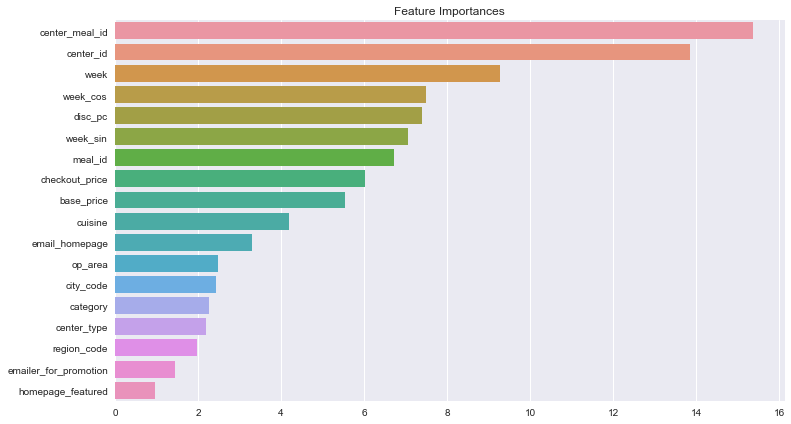

In [104]:
print("Optimal Hyperparameters:")
for param, v in params.items():
    print("{}: {}".format(param, model.get_all_params()[param]))
print("="*50)
sns.barplot(np.sort(model.feature_importances_)[::-1], np.take(features, np.argsort(model.feature_importances_))[::-1])
plt.title('Feature Importances')
plt.show()

In [105]:
y_pred = model.predict(test[features])
y_pred = np.expm1(y_pred)
y_pred = np.array([int(i) for i in y_pred])
y_pred[y_pred<0]

array([], dtype=int32)

In [106]:
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.head()
sub_df.to_csv('submitfile_8.csv', index=False)

## New center & meal specific features 

In [108]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,disc_pc,...,region_code,center_type,op_area,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos,num_orders_log1p
0,1379560,1,55,1885,136.83,152.29,0,0,177,10.151684,...,56,TYPE_C,2.0,Beverages,Thai,0,647_1885,0.120537,0.992709,5.181784
1,1466964,1,55,1993,136.83,135.83,0,0,270,-0.736214,...,56,TYPE_C,2.0,Beverages,Thai,0,647_1993,0.120537,0.992709,5.602119
2,1346989,1,55,2539,134.86,135.86,0,0,189,0.736052,...,56,TYPE_C,2.0,Beverages,Thai,0,647_2539,0.120537,0.992709,5.247024
3,1338232,1,55,2139,339.50,437.53,0,0,54,22.405321,...,56,TYPE_C,2.0,Beverages,Indian,0,647_2139,0.120537,0.992709,4.007333
4,1448490,1,55,2631,243.50,242.50,0,0,40,-0.412371,...,56,TYPE_C,2.0,Beverages,Indian,0,647_2631,0.120537,0.992709,3.713572


In [129]:
center_group = pd.DataFrame(train.groupby(['center_id'])[
                            'num_orders'].mean()).rename(columns={'num_orders': 'center_avg'})
train = pd.merge(train, center_group, how='left', on='center_id')
test = pd.merge(test, center_group, how='left', on='center_id')

meal_group = pd.DataFrame(train.groupby(['meal_id'])['num_orders'].mean()).rename(
    columns={'num_orders': 'meal_avg'})
train = pd.merge(train, meal_group, how='left', on='meal_id')
test = pd.merge(test, meal_group, how='left', on='meal_id')

center_meal_group = pd.DataFrame(train.groupby(['center_id', 'meal_id'])[
                                 'num_orders'].mean()).rename(columns={'num_orders': 'center_meal_avg'})
train = pd.merge(train, center_meal_group, how='left', on=['center_id', 'meal_id'])
test = pd.merge(test, center_meal_group, how='left', on=['center_id', 'meal_id'])

train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,disc_pc,...,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos,num_orders_log1p,center_avg,meal_avg,center_meal_avg
0,1379560,1,55,1885,136.83,152.29,0,0,177,10.151684,...,Beverages,Thai,0,647_1885,0.120537,0.992709,5.181784,163.475709,752.456365,230.324138
1,1466964,1,55,1993,136.83,135.83,0,0,270,-0.736214,...,Beverages,Thai,0,647_1993,0.120537,0.992709,5.602119,163.475709,598.853544,246.972414
2,1346989,1,55,2539,134.86,135.86,0,0,189,0.736052,...,Beverages,Thai,0,647_2539,0.120537,0.992709,5.247024,163.475709,309.494594,190.555556
3,1338232,1,55,2139,339.50,437.53,0,0,54,22.405321,...,Beverages,Indian,0,647_2139,0.120537,0.992709,4.007333,163.475709,42.813462,21.792079
4,1448490,1,55,2631,243.50,242.50,0,0,40,-0.412371,...,Beverages,Indian,0,647_2631,0.120537,0.992709,3.713572,163.475709,104.239051,55.589147


In [130]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,...,op_area,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos,center_avg,meal_avg,center_meal_avg
0,1028232,146,55,1885,158.11,159.11,0,0,0.628496,647,...,2.0,Beverages,Thai,0,647_1885,-0.935016,0.354605,163.475709,752.456365,230.324138
1,1127204,146,55,1993,160.11,159.11,0,0,-0.628496,647,...,2.0,Beverages,Thai,0,647_1993,-0.935016,0.354605,163.475709,598.853544,246.972414
2,1212707,146,55,2539,157.14,159.14,0,0,1.256755,647,...,2.0,Beverages,Thai,0,647_2539,-0.935016,0.354605,163.475709,309.494594,190.555556
3,1082698,146,55,2631,162.02,162.02,0,0,0.000000,647,...,2.0,Beverages,Indian,0,647_2631,-0.935016,0.354605,163.475709,104.239051,55.589147
4,1400926,146,55,1248,163.93,163.93,0,0,0.000000,647,...,2.0,Beverages,Indian,0,647_1248,-0.935016,0.354605,163.475709,88.011872,44.548387


In [131]:
center_meal_group = pd.DataFrame(train.groupby(['center_id', 'meal_id'])[
                                 'num_orders'].median()).rename(columns={'num_orders': 'center_meal_median'})
train = pd.merge(train, center_meal_group, how='left', on=['center_id', 'meal_id'])
test = pd.merge(test, center_meal_group, how='left', on=['center_id', 'meal_id'])
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'disc_pc',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine', 'email_homepage', 'center_meal_id', 'week_sin', 'week_cos',
       'num_orders_log1p', 'center_avg', 'meal_avg', 'center_meal_avg',
       'center_meal_median'],
      dtype='object')

In [132]:
test.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'disc_pc', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'email_homepage', 'center_meal_id', 'week_sin', 'week_cos',
       'center_avg', 'meal_avg', 'center_meal_avg', 'center_meal_median'],
      dtype='object')

In [133]:
features = np.array([c for c in train.columns if c not in ['id', 'num_orders', 'num_orders_log1p']])
for i, c in enumerate(features):
    print("{}: {}".format(i, c))

0: week
1: center_id
2: meal_id
3: checkout_price
4: base_price
5: emailer_for_promotion
6: homepage_featured
7: disc_pc
8: city_code
9: region_code
10: center_type
11: op_area
12: category
13: cuisine
14: email_homepage
15: center_meal_id
16: week_sin
17: week_cos
18: center_avg
19: meal_avg
20: center_meal_avg
21: center_meal_median


In [134]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.05, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9],
          'iterations': [1000, 1500, 2000, 2500],
          'one_hot_max_size': [51, 77]
         }

cat_indices = [1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]

train_pool = Pool(train[features], train['num_orders_log1p'], cat_features=cat_indices)

model = CatBoostRegressor(task_type='GPU', early_stopping_rounds=50)
grid_search_results = model.randomized_search(params, train_pool, shuffle=False, verbose=3, n_iter=100)

0:	loss: 0.5056055	best: 0.5056055 (0)	total: 17.2s	remaining: 28m 25s
3:	loss: 0.5056966	best: 0.5053587 (1)	total: 1m 34s	remaining: 37m 43s
6:	loss: 0.5071880	best: 0.5037084 (5)	total: 2m 47s	remaining: 37m 1s
9:	loss: 0.5115828	best: 0.5037084 (5)	total: 3m 33s	remaining: 32m 5s
12:	loss: 0.5071972	best: 0.5037084 (5)	total: 4m 29s	remaining: 30m 4s
15:	loss: 0.5053587	best: 0.5037084 (5)	total: 5m 28s	remaining: 28m 43s
18:	loss: 0.5102163	best: 0.5037084 (5)	total: 6m 25s	remaining: 27m 23s
21:	loss: 0.5083384	best: 0.5037084 (5)	total: 7m 17s	remaining: 25m 52s
24:	loss: 0.5059501	best: 0.5037084 (5)	total: 7m 55s	remaining: 23m 46s
27:	loss: 0.5102163	best: 0.5037084 (5)	total: 8m 47s	remaining: 22m 37s
30:	loss: 0.5054674	best: 0.5037084 (5)	total: 9m 56s	remaining: 22m 7s
33:	loss: 0.5152652	best: 0.5037084 (5)	total: 10m 33s	remaining: 20m 29s
36:	loss: 0.5133607	best: 0.5037084 (5)	total: 11m 10s	remaining: 19m 1s
39:	loss: 0.5054674	best: 0.5037084 (5)	total: 12m 23s	rema

In [135]:
grid_search_results['params']

{'depth': 4,
 'one_hot_max_size': 51,
 'l2_leaf_reg': 9,
 'iterations': 1000,
 'learning_rate': 0.1}

Optimal Hyperparameters:
one_hot_max_size: 51
learning_rate: 0.1000000015
depth: 4
l2_leaf_reg: 9
iterations: 1000


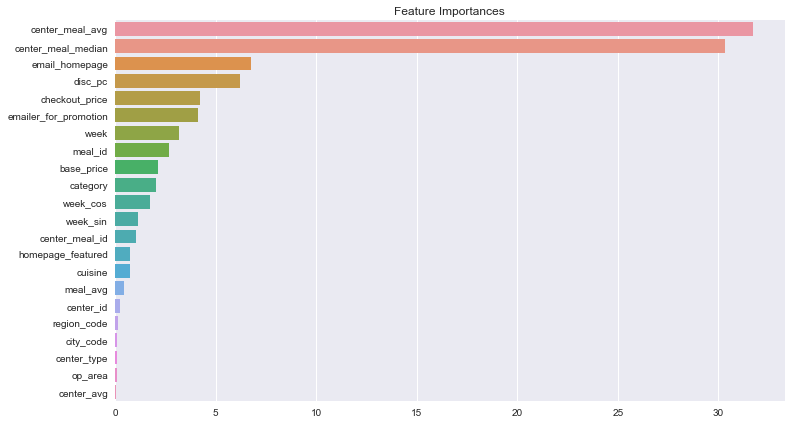

In [136]:
print("Optimal Hyperparameters:")
for param, v in params.items():
    print("{}: {}".format(param, model.get_all_params()[param]))
print("="*50)
sns.barplot(np.sort(model.feature_importances_)[::-1], np.take(features, np.argsort(model.feature_importances_))[::-1])
plt.title('Feature Importances')
plt.show()

In [137]:
y_pred = model.predict(test[features])
y_pred = np.expm1(y_pred)
y_pred = np.array([int(i) for i in y_pred])
y_pred[y_pred<0]

array([], dtype=int32)

In [138]:
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.head()
sub_df.to_csv('submitfile_8.csv', index=False)

### Random Forest

In [155]:
train_dates = train_new.index
test_dates = test_new.index
train_new.reset_index(drop=True, inplace=True)
test_new.reset_index(drop=True, inplace=True)

In [156]:
train_new['center_avg'] = train['center_avg']
train_new['meal_avg'] = train['meal_avg']
train_new['center_meal_avg'] = train['center_meal_avg']
train_new['center_meal_median'] = train['center_meal_median']

test_new['center_avg'] = test['center_avg']
test_new['meal_avg'] = test['meal_avg']
test_new['center_meal_avg'] = test['center_meal_avg']
test_new['center_meal_median'] = test['center_meal_median']

In [160]:
train_new.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,disc_pc,city_code,region_code,...,category,cuisine,email_homepage,center_meal_id,week_sin,week_cos,center_avg,meal_avg,center_meal_avg,center_meal_median
0,1,23,22,136.83,152.29,0,0,10.151684,30,3,...,0,3,0,1415,0.120537,0.992709,163.475709,752.456365,230.324138,215.0
1,1,23,26,136.83,135.83,0,0,-0.736214,30,3,...,0,3,0,1419,0.120537,0.992709,163.475709,598.853544,246.972414,231.0
2,1,23,38,134.86,135.86,0,0,0.736052,30,3,...,0,3,0,1430,0.120537,0.992709,163.475709,309.494594,190.555556,176.0
3,1,23,29,339.50,437.53,0,0,22.405321,30,3,...,0,1,0,1421,0.120537,0.992709,163.475709,42.813462,21.792079,15.0
4,1,23,42,243.50,242.50,0,0,-0.412371,30,3,...,0,1,0,1434,0.120537,0.992709,163.475709,104.239051,55.589147,53.0


In [177]:
test_new.isna().any()

week                     False
center_id                False
meal_id                  False
checkout_price           False
base_price               False
emailer_for_promotion    False
homepage_featured        False
disc_pc                  False
city_code                False
region_code              False
center_type              False
op_area                  False
category                 False
cuisine                  False
email_homepage           False
center_meal_id           False
week_sin                 False
week_cos                 False
center_avg               False
meal_avg                 False
center_meal_avg           True
center_meal_median        True
dtype: bool

In [179]:
test_new.fillna(method='ffill', inplace=True)
test_new.isna().sum()

week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
disc_pc                  0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
email_homepage           0
center_meal_id           0
week_sin                 0
week_cos                 0
center_avg               0
meal_avg                 0
center_meal_avg          0
center_meal_median       0
dtype: int64

In [162]:
rf_params = {
    'n_estimators': [10, 50, 100, 300],
    'max_depth': [50, 100, 150]
}
from sklearn.model_selection import TimeSeriesSplit
model_rf = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=rf_params, scoring='neg_mean_squared_error')
model_rf.fit(train_new, train['num_orders_log1p'])

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [50, 100, 150],

In [163]:
model_rf.best_params_

{'max_depth': 150, 'n_estimators': 300}

In [164]:
model.best_score_

{'learn': {'RMSE': 0.46386002744033583}}

In [180]:
y_pred = model_rf.predict(test_new)
y_pred = np.expm1(y_pred)
y_pred = np.array([int(i) for i in y_pred])
print(y_pred[y_pred<0])

## Test Score - 52.868 - LB-86
sub_df = pd.DataFrame({'id': test['id'], 'num_orders': y_pred})
sub_df.head()
sub_df.to_csv('submitfile_rf1.csv', index=False)

[]
